## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from pulp import (
    LpProblem, LpVariable, LpBinary, LpInteger,
    LpMaximize, lpSum, PULP_CBC_CMD
)

## 2. Import Data

In [2]:
# 1) 데이터 로드
df_sku   = pd.read_csv('../data_real/발주수량.csv')   # columns: PART_CD, COLOR_CD, Size, Quantity
df_store = pd.read_csv('../data_real/매장데이터.csv') # columns: SHOP_ID, QTY_SUM

print(df_store.head())
print(df_sku.head())

   SHOP_ID                 SHOP_NM  QTY_SUM
0    30040   (주)에프앤에프 디스커버리 팩토리아울렛     7571
1    30025      (주)에프앤에프 신세계사이먼시흥점     7225
2    10050                   롯데쇼핑㈜     6444
3    30019  (주)에프앤에프 디스커버리 롯데아울렛김해     5691
4    30041              (주)에프앤에프용인     5199
     PART_CD COLOR_CD SIZE_CD  ORD_QTY
0  DMDJ85046      BGD      95      230
1  DMDJ85046      BGD     100      400
2  DMDJ85046      BGD     105      270
3  DMDJ85046      BGD     110      100
4  DMDJ85046      BKS      95      360


In [3]:
# SKU 식별자 및 공급량 A_i
df_sku['SKU'] = df_sku['PART_CD'] + '_' + df_sku['COLOR_CD'] + '_' + df_sku['SIZE_CD']
A = df_sku.set_index('SKU')['ORD_QTY'].to_dict()
SKUs = list(A.keys())

# 매장 리스트 및 판매량 합 QTY_SUM
stores = df_store['SHOP_ID'].tolist()
QSUM   = df_store.set_index('SHOP_ID')['QTY_SUM'].to_dict()

In [7]:
# 2) 희소/충분 SKU 분류
num_stores = len(stores)
# 기본 희소 SKU 식별
basic_scarce = [i for i,qty in A.items() if qty < num_stores]

# 확장된 희소 SKU 그룹 생성
extended_scarce = set(basic_scarce)

for scarce_sku in basic_scarce:
    # 해당 SKU의 스타일, 색상, 사이즈 추출
    style = df_sku.loc[df_sku['SKU']==scarce_sku, 'PART_CD'].iloc[0]
    color = df_sku.loc[df_sku['SKU']==scarce_sku, 'COLOR_CD'].iloc[0]
    size = df_sku.loc[df_sku['SKU']==scarce_sku, 'SIZE_CD'].iloc[0]
    
    # 동일 스타일에서 관련 SKU들 찾기
    same_style_skus = df_sku[df_sku['PART_CD'] == style]['SKU'].tolist()
    
    for related_sku in same_style_skus:
        if related_sku in SKUs:  # 실제 존재하는 SKU인지 확인
            related_color = df_sku.loc[df_sku['SKU']==related_sku, 'COLOR_CD'].iloc[0]
            related_size = df_sku.loc[df_sku['SKU']==related_sku, 'SIZE_CD'].iloc[0]
            
            # 같은 색상 다른 사이즈 OR 같은 사이즈 다른 색상
            if (color == related_color and size != related_size) or \
               (color != related_color and size == related_size):
                extended_scarce.add(related_sku)

scarce = list(extended_scarce)
abundant = [i for i in SKUs if i not in scarce]

print(scarce)
print(abundant)

['DXDJ8C046_BKN_90', 'DXDJ8C046_BKP_95', 'DXDJ8C046_IVS_90', 'DXDJ8C046_BKP_90', 'DWLG42044_KAD_L', 'DXDJ8C046_GRP_100', 'DXDJ8C046_BES_90', 'DXDJ8C046_GRS_90', 'DXDJ8C046_IVS_110', 'DWLG42044_BKS_L', 'DXDJ8C046_GRP_110', 'DXDJ8C046_BKP_110', 'DXDJ8C046_BES_110', 'DXDJ8C046_BKP_100', 'DWLG42044_KAD_M', 'DXDJ8C046_GRN_110', 'DXDJ8C046_GRN_90', 'DXDJ8C046_BKS_110', 'DXDJ8C046_BKS_90', 'DWLG42044_BKS_XS', 'DWLG42044_KAD_XS', 'DXDJ8C046_BKN_110', 'DWLG42044_KAD_S', 'DXDJ8C046_GRP_105', 'DXDJ8C046_GRS_110', 'DWLG42044_BKS_S', 'DXDJ8C046_OLD_110', 'DXDJ8C046_GRP_95', 'DXDJ8C046_GRP_90', 'DWLG42044_BKS_M', 'DXDJ8C046_BKP_105']
['DMDJ85046_BGD_95', 'DMDJ85046_BGD_100', 'DMDJ85046_BGD_105', 'DMDJ85046_BGD_110', 'DMDJ85046_BKS_95', 'DMDJ85046_BKS_100', 'DMDJ85046_BKS_105', 'DMDJ85046_BKS_110', 'DMDJ85046_IVD_95', 'DMDJ85046_IVD_100', 'DMDJ85046_IVD_105', 'DMDJ85046_IVD_110', 'DWDJ68046_BKS_85', 'DWDJ68046_BKS_90', 'DWDJ68046_BKS_95', 'DWDJ68046_BKS_100', 'DWDJ68046_BKS_105', 'DWDJ68046_GRD_85', 

In [8]:
# 3) 스타일·색상·사이즈 그룹 생성
styles = df_sku['PART_CD'].unique().tolist()
I_s     = {s: df_sku[df_sku['PART_CD']==s]['SKU'].tolist() for s in styles}
K_s     = {s: df_sku[df_sku['PART_CD']==s]['COLOR_CD'].unique().tolist() for s in styles}
L_s     = {s: df_sku[df_sku['PART_CD']==s]['SIZE_CD'].unique().tolist()  for s in styles}

# # 4) 1단계 할당 상한 M_j 계산 (QTY_SUM 대비 비례)
# # M_j: 매장 j가 받을 수 있는 희소 SKU 개수
# avg_qty    = df_store['QTY_SUM'].mean()
# baseline_M = 12
# df_store['M_j'] = np.maximum(
#     1,
#     (df_store['QTY_SUM'] / avg_qty * baseline_M).round().astype(int)
# )
# M = df_store.set_index('SHOP_ID')['M_j'].to_dict()

print(stores)
print(styles)
print(I_s)
print(K_s)
print(L_s)
# print(M)

[30040, 30025, 10050, 30019, 30041, 10070, 10007, 30038, 30044, 30032, 30042, 30045, 10018, 30051, 30035, 30039, 30016, 50077, 30011, 30007, 50195, 50185, 30023, 50096, 50001, 30024, 50023, 10061, 30049, 10069, 30020, 10047, 30046, 10096, 30053, 50089, 10068, 10077, 50065, 10056, 10025, 10075, 10064, 10003, 30054, 10011, 30033, 30010, 50210, 50118, 50193, 10087, 10097, 10046, 50186, 50074, 10021, 50205, 50101, 10027, 30037, 10055, 50126, 10057, 30043, 10009, 50146, 10091, 50207, 10035, 50098, 30030, 50162, 30034, 30031, 10038, 50180, 50121, 10060, 50063, 50120, 50053, 50179, 10044, 10063, 10078, 10023, 50106, 50134, 10053, 50151, 50007, 10004, 10079, 30028, 30022, 10059, 10043, 30015, 50057]
['DMDJ85046', 'DWDJ68046', 'DWDJ8P046', 'DWLG42044', 'DXDJ8C046', 'DXMT33044']
{'DMDJ85046': ['DMDJ85046_BGD_95', 'DMDJ85046_BGD_100', 'DMDJ85046_BGD_105', 'DMDJ85046_BGD_110', 'DMDJ85046_BKS_95', 'DMDJ85046_BKS_100', 'DMDJ85046_BKS_105', 'DMDJ85046_BKS_110', 'DMDJ85046_IVD_95', 'DMDJ85046_IVD_100'

## Step 1: Coverage MILP

In [9]:
# === STEP1: Coverage MILP (희소 SKU 커버리지 최적화) ===
# 목적: 수량이 적은 희소 SKU들을 전략적으로 배치하여 각 매장이 
#       다양한 스타일의 색상과 사이즈를 커버할 수 있도록 최적화

prob1 = LpProblem('Step1_Coverage', LpMaximize)

# ===== 변수 정의 =====
# b[i][j]: 희소 SKU i를 매장 j에 할당할지 여부 (0 또는 1)
#          예: b['DWLG42044_BKS_XS'][30040] = 1 이면 
#              XS 사이즈 BKS 색상 상품을 매장 30040에 할당
b = LpVariable.dicts('b', (scarce, stores), cat=LpBinary)

# color_coverage[s,j]: 매장 j가 스타일 s의 색상을 몇 개 커버하는지
color_coverage = {
    (s,j): LpVariable(f"color_coverage_{s}_{j}", lowBound=0, upBound=len(K_s[s]), cat=LpInteger)
    for s in styles for j in stores
}

# size_coverage[s,j]: 매장 j가 스타일 s의 사이즈를 몇 개 커버하는지
size_coverage = {
    (s,j): LpVariable(f"size_coverage_{s}_{j}", lowBound=0, upBound=len(L_s[s]), cat=LpInteger)
    for s in styles for j in stores
}

# ===== 목적함수 =====
# 전체 커버리지 최대화: 색상 커버리지 + 사이즈 커버리지 + 할당 보너스
epsilon = 0.001  # 타이브레이커: 동일한 커버리지면 더 많은 할당을 선호
prob1 += (
    lpSum(color_coverage[s,j] for s in styles for j in stores) +  # 색상 커버리지 합계
    lpSum(size_coverage[s,j] for s in styles for j in stores) +  # 사이즈 커버리지 합계
    epsilon * lpSum(b[i][j] for i in scarce for j in stores)           # 할당량 보너스
)

# ===== 제약조건 =====

# 1) 희소 SKU 공급량 제한
# 각 희소 SKU의 총 할당량은 공급 가능한 수량을 초과할 수 없음
# 예: DWLG42044_BKS_XS는 총 70개까지만 할당 가능
for i in scarce:
    prob1 += lpSum(b[i][j] for j in stores) <= A[i]

# # 2) 매장별 1단계 할당 상한
# # 각 매장이 받을 수 있는 희소 SKU 개수 제한 (매장 규모에 비례)
# # 예: 매장 30040은 최대 M[30040]개의 희소 SKU만 받을 수 있음
# for j in stores:
#     prob1 += lpSum(b[i][j] for i in scarce) <= M[j]

# 3) 색상 커버리지 개수 제약조건 - 직접 연결
# 매장 j가 스타일 s에서 커버하는 색상 개수는 실제 할당받은 색상 종류 수와 같아야 함
for s in styles:
    for j in stores:
        # 각 색상별로 이진 변수 생성 (해당 색상을 커버하는지)
        color_covered = {}
        for k in K_s[s]:
            color_covered[k] = LpVariable(f"color_covered_{s}_{k}_{j}", cat=LpBinary)
            
            # 해당 색상의 희소 SKU들
            idx_color = [i for i in I_s[s] if df_sku.loc[df_sku['SKU']==i,'COLOR_CD'].iloc[0]==k and i in scarce]
            
            if idx_color:
                # 해당 색상의 SKU를 하나라도 받으면 색상 커버됨
                prob1 += lpSum(b[i][j] for i in idx_color) >= color_covered[k]
                # 색상이 커버되지 않으면 해당 색상 SKU 할당 불가
                for i in idx_color:
                    prob1 += b[i][j] <= color_covered[k]
            else:
                # 희소 SKU가 없는 색상은 커버 불가
                prob1 += color_covered[k] == 0
        
        # 커버리지 개수 = 커버된 색상들의 합
        prob1 += color_coverage[s,j] == lpSum(color_covered[k] for k in K_s[s])

# 4) 사이즈 커버리지 개수 제약조건 - 직접 연결
for s in styles:
    for j in stores:
        # 각 사이즈별로 이진 변수 생성 (해당 사이즈를 커버하는지)
        size_covered = {}
        for l in L_s[s]:
            size_covered[l] = LpVariable(f"size_covered_{s}_{l}_{j}", cat=LpBinary)
            
            # 해당 사이즈의 희소 SKU들
            idx_size = [i for i in I_s[s] if df_sku.loc[df_sku['SKU']==i,'SIZE_CD'].iloc[0]==l and i in scarce]
            
            if idx_size:
                # 해당 사이즈의 SKU를 하나라도 받으면 사이즈 커버됨
                prob1 += lpSum(b[i][j] for i in idx_size) >= size_covered[l]
                # 사이즈가 커버되지 않으면 해당 사이즈 SKU 할당 불가
                for i in idx_size:
                    prob1 += b[i][j] <= size_covered[l]
            else:
                # 희소 SKU가 없는 사이즈는 커버 불가
                prob1 += size_covered[l] == 0
        
        # 커버리지 개수 = 커버된 사이즈들의 합
        prob1 += size_coverage[s,j] == lpSum(size_covered[l] for l in L_s[s])

# 5) 최적화 문제 해결
print("Step1 Coverage 최적화 시작...")
prob1.solve(PULP_CBC_CMD(msg=False))

# 6) 1단계 결과 저장
# b_hat[i,j]: 희소 SKU i가 매장 j에 할당되었는지 여부 (0 또는 1)
# 이 결과는 Step2에서 최소 할당량 보장 제약조건으로 사용됨
b_hat = {(i,j): int(b[i][j].value()) for i in scarce for j in stores}

if prob1.status == 1:
    print("Step1 Coverage 최적화 완료!")
else:
    print(f"Step1 Coverage 최적화 실패: {prob1.status}")

Step1 Coverage 최적화 시작...
Step1 Coverage 최적화 완료!


In [11]:
# b_hat

## Step 2: Quantity ILP

In [12]:
# === STEP2: Quantity ILP ===
print("Step2 최적화 시작...")
prob2 = LpProblem('Step2_Quantity', LpMaximize)

# 변수 정의
x = LpVariable.dicts('x', (SKUs, stores), lowBound=0, cat=LpInteger)

# 매장 가중치 w_j = QTY_SUM_j / total_QTY_SUM
total_qty = sum(QSUM.values())
w = {j: QSUM[j] / total_qty for j in stores}

# 목적함수: 가중치 기반 최적 배분 (모든 재고를 다 분배하므로 총량은 동일)
prob2 += lpSum(w[j] * x[i][j] for i in SKUs for j in stores)

# 1) 모든 SKU 공급량 완전 소진 (등식 제약조건)
for i in SKUs:
    prob2 += lpSum(x[i][j] for j in stores) == A[i]

# 2) 1단계 커버리지 보장 (scarce SKU)
for (i,j), val in b_hat.items():
    if val == 1:
        prob2 += x[i][j] >= 1

# 3) 매장별 용량 제한 완화 (더 많은 분배를 위해 크게 증가)
for j in stores:
    # 각 매장의 용량을 크게 증가 (QTY_SUM 기반 동적 할당)
    # 매장 규모에 비례하되 충분히 여유있게 설정
    capacity_j = max(500, int(QSUM[j] / 10))  # 최소 500개, 또는 판매량의 1/10
    prob2 += lpSum(x[i][j] for i in SKUs) <= capacity_j

# 4) 풍부한 SKU의 최소 배분 보장 (선택적 - 복잡도 때문에 주석 처리)
# for i in abundant:
#     # 각 풍부한 SKU는 최소한 일정 비율의 매장에 배분
#     min_stores = max(1, min(len(stores)//10, 10))  # 최소 1개, 최대 10개 매장
#     y = LpVariable.dicts(f'y_{i}', stores, cat=LpBinary)
#     prob2 += lpSum(y[j] for j in stores) >= min_stores
#     for j in stores:
#         prob2 += x[i][j] >= y[j]
#         prob2 += x[i][j] <= A[i] * y[j]  # Big-M 제약

# 5) ILP 풀기
prob2.solve(PULP_CBC_CMD(msg=False))

# 결과 확인
if prob2.status == 1:
    print("Step2 최적화 완료!")
else:
    print(f"Step2 최적화 실패: {prob2.status}")

# 6) 결과 분석 및 출력
print("\n=== Step1 Coverage 결과 (scarce SKU) ===")
scarce_assignments = [(i,j,val) for (i,j), val in b_hat.items() if val == 1]
print(f"희소 SKU 할당 건수: {len(scarce_assignments)}")

# scarce SKU별 할당 현황
scarce_allocation_count = {}
for i,j,val in scarce_assignments:
    scarce_allocation_count[i] = scarce_allocation_count.get(i, 0) + 1

print("\n희소 SKU별 할당 매장 수:")
for i in scarce:
    count = scarce_allocation_count.get(i, 0)
    print(f"{i}: {count}/{len(stores)} 매장 (공급량: {A[i]})")

print(f"\n=== Step2 Final Allocation 결과 ===")
# 전체 할당 결과 집계
total_allocated = {}
store_totals = {}
sku_totals = {}

for i in SKUs:
    sku_total = 0
    for j in stores:
        qty = int(x[i][j].value()) if x[i][j].value() else 0
        if qty > 0:
            sku_total += qty
            store_totals[j] = store_totals.get(j, 0) + qty
            
    if sku_total > 0:
        sku_totals[i] = sku_total
        total_allocated[i] = sku_total

# 결과 요약
print(f"총 할당된 SKU 종류: {len(total_allocated)}")
print(f"총 할당 수량: {sum(total_allocated.values())}")
print(f"공급 가능 총량: {sum(A.values())}")
print(f"할당률: {sum(total_allocated.values())/sum(A.values())*100:.1f}% (완전 소진!)")
print(f"평균 매장당 할당량: {sum(store_totals.values()) / len(stores):.1f}")
print(f"최대 매장 할당량: {max(store_totals.values()) if store_totals else 0}")
print(f"최소 매장 할당량: {min(store_totals.values()) if store_totals else 0}")

# 상위 할당량 SKU 출력
print("\n=== 상위 할당량 SKU Top 10 ===")
sorted_skus = sorted(sku_totals.items(), key=lambda x: x[1], reverse=True)
for i, (sku, qty) in enumerate(sorted_skus[:10]):
    allocation_rate = qty / A[sku] * 100
    print(f"{i+1}. {sku}: {qty}개/{A[sku]}개 ({allocation_rate:.1f}%)")

# 상위 할당량 매장 출력  
print("\n=== 상위 할당량 매장 Top 10 ===")
sorted_stores = sorted(store_totals.items(), key=lambda x: x[1], reverse=True)
for i, (store, qty) in enumerate(sorted_stores[:10]):
    capacity = max(500, int(QSUM[store] / 10))  # 새로운 용량 계산 공식 적용
    capacity_rate = qty / capacity * 100 if capacity > 0 else 0
    print(f"{i+1}. 매장 {store}: {qty}개 (용량: {capacity}, 이용률: {capacity_rate:.1f}%)")

# 희소 SKU 할당 확인
print("\n=== 희소 SKU 할당 확인 ===")
for i in scarce:
    total_assigned = sum(int(x[i][j].value()) if x[i][j].value() else 0 for j in stores)
    coverage_stores = sum(1 for j in stores if x[i][j].value() and x[i][j].value() > 0)
    print(f"{i}: {total_assigned}개 할당, {coverage_stores}개 매장 (공급량: {A[i]})")

# 샘플 할당 결과
print("\n=== 샘플 할당 결과 (수량 > 0인 경우만) ===")
sample_count = 0
for i in SKUs:
    if sample_count >= 15:
        break
    for j in stores:
        qty = int(x[i][j].value()) if x[i][j].value() else 0
        if qty > 0:
            print(f"{i} → 매장 {j}: {qty}개")
            sample_count += 1
            if sample_count >= 15:
                break


Step2 최적화 시작...
Step2 최적화 실패: -1

=== Step1 Coverage 결과 (scarce SKU) ===
희소 SKU 할당 건수: 2830

희소 SKU별 할당 매장 수:
DXDJ8C046_BKN_90: 100/100 매장 (공급량: 150)
DXDJ8C046_BKP_95: 100/100 매장 (공급량: 110)
DXDJ8C046_IVS_90: 100/100 매장 (공급량: 370)
DXDJ8C046_BKP_90: 40/100 매장 (공급량: 40)
DWLG42044_KAD_L: 100/100 매장 (공급량: 200)
DXDJ8C046_GRP_100: 100/100 매장 (공급량: 160)
DXDJ8C046_BES_90: 100/100 매장 (공급량: 110)
DXDJ8C046_GRS_90: 100/100 매장 (공급량: 280)
DXDJ8C046_IVS_110: 100/100 매장 (공급량: 100)
DWLG42044_BKS_L: 100/100 매장 (공급량: 300)
DXDJ8C046_GRP_110: 60/100 매장 (공급량: 60)
DXDJ8C046_BKP_110: 60/100 매장 (공급량: 60)
DXDJ8C046_BES_110: 100/100 매장 (공급량: 140)
DXDJ8C046_BKP_100: 100/100 매장 (공급량: 160)
DWLG42044_KAD_M: 100/100 매장 (공급량: 360)
DXDJ8C046_GRN_110: 100/100 매장 (공급량: 120)
DXDJ8C046_GRN_90: 100/100 매장 (공급량: 120)
DXDJ8C046_BKS_110: 100/100 매장 (공급량: 1270)
DXDJ8C046_BKS_90: 100/100 매장 (공급량: 640)
DWLG42044_BKS_XS: 70/100 매장 (공급량: 70)
DWLG42044_KAD_XS: 60/100 매장 (공급량: 60)
DXDJ8C046_BKN_110: 100/100 매장 (공급량: 250)
DWLG42044_KAD

In [13]:
# 결과를 DataFrame으로 정리하고 CSV 저장
allocation_results = []

for i in SKUs:
    for j in stores:
        qty = int(x[i][j].value()) if x[i][j].value() else 0
        if qty > 0:
            # SKU 정보 파싱
            part_cd, color_cd, size_cd = i.split('_')
            allocation_results.append({
                'SKU': i,
                'PART_CD': part_cd,
                'COLOR_CD': color_cd,
                'SIZE_CD': size_cd,
                'SHOP_ID': j,
                'ALLOCATED_QTY': qty,
                'SUPPLY_QTY': A[i],
                'SKU_TYPE': 'scarce' if i in scarce else 'abundant',
                'STEP1_ASSIGNED': 1 if (i,j) in b_hat and b_hat[(i,j)] == 1 else 0
            })

df_results = pd.DataFrame(allocation_results)

if len(df_results) > 0:
    # CSV 파일로 저장
    df_results.to_csv('../output/step2_allocation_results.csv', index=False, encoding='utf-8-sig')
    print(f"\n결과가 '../output/step2_allocation_results.csv'에 저장되었습니다.")
    print(f"총 {len(df_results)} 건의 할당 결과")
    
    # 요약 통계
    print(f"\n=== 할당 결과 요약 ===")
    print(df_results.groupby('SKU_TYPE').agg({
        'SKU': 'nunique',
        'ALLOCATED_QTY': 'sum',
        'SHOP_ID': 'nunique'
    }).rename(columns={'SKU': 'SKU_COUNT', 'SHOP_ID': 'STORE_COUNT'}))
    
    # 매장별 할당 현황
    store_summary = df_results.groupby('SHOP_ID').agg({
        'SKU': 'nunique',
        'ALLOCATED_QTY': 'sum'
    }).rename(columns={'SKU': 'SKU_COUNT', 'ALLOCATED_QTY': 'TOTAL_QTY'})
    store_summary['CAPACITY'] = store_summary.index.map(lambda x: max(500, int(QSUM[x] / 10)))
    store_summary['UTILIZATION_RATE'] = store_summary['TOTAL_QTY'] / store_summary['CAPACITY'] * 100
    
    # 매장별 요약도 저장
    store_summary.to_csv('../output/step2_store_summary.csv', encoding='utf-8-sig')
    print(f"매장별 요약이 '../output/step2_store_summary.csv'에 저장되었습니다.")
else:
    print("할당 결과가 없습니다.")



결과가 '../output/step2_allocation_results.csv'에 저장되었습니다.
총 3042 건의 할당 결과

=== 할당 결과 요약 ===
          SKU_COUNT  ALLOCATED_QTY  STORE_COUNT
SKU_TYPE                                       
abundant        117         122430           99
scarce           31           6870          100
매장별 요약이 '../output/step2_store_summary.csv'에 저장되었습니다.


## 시각화

In [14]:
# ===== 배분 결과 평가 메트릭 계산 및 시각화 =====
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("\n" + "="*60)
print("         배분 결과 평가 메트릭 분석")
print("="*60)

# ===== 1. 매장별 커버리지 계산 =====
print("\n1️⃣ 매장별 스타일 커버리지 계산 중...")

# 각 매장이 커버하는 스타일별 색상과 사이즈 계산
store_coverage = {}
for j in stores:
    store_coverage[j] = {}
    for s in styles:
        # 해당 매장에서 할당받은 SKU들
        allocated_skus = [i for i in SKUs if x[i][j].value() and x[i][j].value() > 0 and i.startswith(s)]
        
        # 커버된 색상들
        covered_colors = set()
        for sku in allocated_skus:
            color = df_sku.loc[df_sku['SKU']==sku, 'COLOR_CD'].iloc[0]
            covered_colors.add(color)
        
        # 커버된 사이즈들
        covered_sizes = set()
        for sku in allocated_skus:
            size = df_sku.loc[df_sku['SKU']==sku, 'SIZE_CD'].iloc[0]
            covered_sizes.add(size)
        
        store_coverage[j][s] = {
            'colors': covered_colors,
            'sizes': covered_sizes,
            'allocated_skus': allocated_skus
        }

# ===== 2. 스타일별 컬러 커버리지 매장 비율 계산 =====
print("2️⃣ 스타일별 컬러 커버리지 비율 계산 중...")

style_color_coverage = {}
for s in styles:
    total_colors = len(K_s[s])  # 해당 스타일의 전체 색상 수
    
    # 각 매장별 커버리지 비율 계산
    store_ratios = []
    for j in stores:
        covered_colors = len(store_coverage[j][s]['colors'])
        ratio = covered_colors / total_colors if total_colors > 0 else 0
        store_ratios.append(ratio)
    
    style_color_coverage[s] = {
        'total_colors': total_colors,
        'store_ratios': store_ratios,
        'avg_ratio': sum(store_ratios) / len(store_ratios),
        'max_ratio': max(store_ratios),
        'min_ratio': min(store_ratios)
    }

# ===== 3. 스타일별 사이즈 커버리지 매장 비율 계산 =====
print("3️⃣ 스타일별 사이즈 커버리지 비율 계산 중...")

style_size_coverage = {}
for s in styles:
    total_sizes = len(L_s[s])  # 해당 스타일의 전체 사이즈 수
    
    # 각 매장별 커버리지 비율 계산
    store_ratios = []
    for j in stores:
        covered_sizes = len(store_coverage[j][s]['sizes'])
        ratio = covered_sizes / total_sizes if total_sizes > 0 else 0
        store_ratios.append(ratio)
    
    style_size_coverage[s] = {
        'total_sizes': total_sizes,
        'store_ratios': store_ratios,
        'avg_ratio': sum(store_ratios) / len(store_ratios),
        'max_ratio': max(store_ratios),
        'min_ratio': min(store_ratios)
    }

# ===== 4. 매장별 분배 적정성 비율 계산 =====
print("4️⃣ 매장별 분배 적정성 비율 계산 중...")

store_allocation_ratio = {}
for j in stores:
    total_allocated = sum(int(x[i][j].value()) if x[i][j].value() else 0 for i in SKUs)
    qty_sum = QSUM[j]
    ratio = total_allocated / qty_sum if qty_sum > 0 else 0
    store_allocation_ratio[j] = {
        'allocated': total_allocated,
        'qty_sum': qty_sum,
        'ratio': ratio
    }

# ===== 결과 요약 출력 =====
print("\n" + "="*50)
print("           📊 평가 메트릭 요약")
print("="*50)

print("\n🎨 스타일별 컬러 커버리지 평균 비율:")
for s in styles:
    avg_ratio = style_color_coverage[s]['avg_ratio']
    total_colors = style_color_coverage[s]['total_colors']
    print(f"  {s}: {avg_ratio:.3f} (평균 {avg_ratio*total_colors:.1f}/{total_colors} 색상)")

print("\n📏 스타일별 사이즈 커버리지 평균 비율:")
for s in styles:
    avg_ratio = style_size_coverage[s]['avg_ratio']
    total_sizes = style_size_coverage[s]['total_sizes']
    print(f"  {s}: {avg_ratio:.3f} (평균 {avg_ratio*total_sizes:.1f}/{total_sizes} 사이즈)")

print("\n⚖️ 매장별 분배 적정성 통계:")
ratios = [data['ratio'] for data in store_allocation_ratio.values()]
print(f"  평균 비율: {sum(ratios)/len(ratios):.4f}")
print(f"  최대 비율: {max(ratios):.4f}")
print(f"  최소 비율: {min(ratios):.4f}")
print(f"  표준편차: {(sum([(r-sum(ratios)/len(ratios))**2 for r in ratios])/len(ratios))**0.5:.4f}")

print("\n✅ 메트릭 계산 완료!")



         배분 결과 평가 메트릭 분석

1️⃣ 매장별 스타일 커버리지 계산 중...
2️⃣ 스타일별 컬러 커버리지 비율 계산 중...
3️⃣ 스타일별 사이즈 커버리지 비율 계산 중...
4️⃣ 매장별 분배 적정성 비율 계산 중...

           📊 평가 메트릭 요약

🎨 스타일별 컬러 커버리지 평균 비율:
  DMDJ85046: 0.053 (평균 0.2/3 색상)
  DWDJ68046: 0.074 (평균 0.4/5 색상)
  DWDJ8P046: 0.066 (평균 0.3/5 색상)
  DWLG42044: 1.000 (평균 2.0/2 색상)
  DXDJ8C046: 1.000 (평균 9.0/9 색상)
  DXMT33044: 0.066 (평균 0.5/7 색상)

📏 스타일별 사이즈 커버리지 평균 비율:
  DMDJ85046: 0.040 (평균 0.2/4 사이즈)
  DWDJ68046: 0.072 (평균 0.4/5 사이즈)
  DWDJ8P046: 0.083 (평균 0.3/4 사이즈)
  DWLG42044: 1.000 (평균 4.0/4 사이즈)
  DXDJ8C046: 0.842 (평균 5.0/6 사이즈)
  DXMT33044: 0.077 (평균 0.5/6 사이즈)

⚖️ 매장별 분배 적정성 통계:
  평균 비율: 0.3775
  최대 비율: 10.4767
  최소 비율: 0.0998
  표준편차: 1.0205

✅ 메트릭 계산 완료!



🎯 평가 메트릭 시각화 시작...


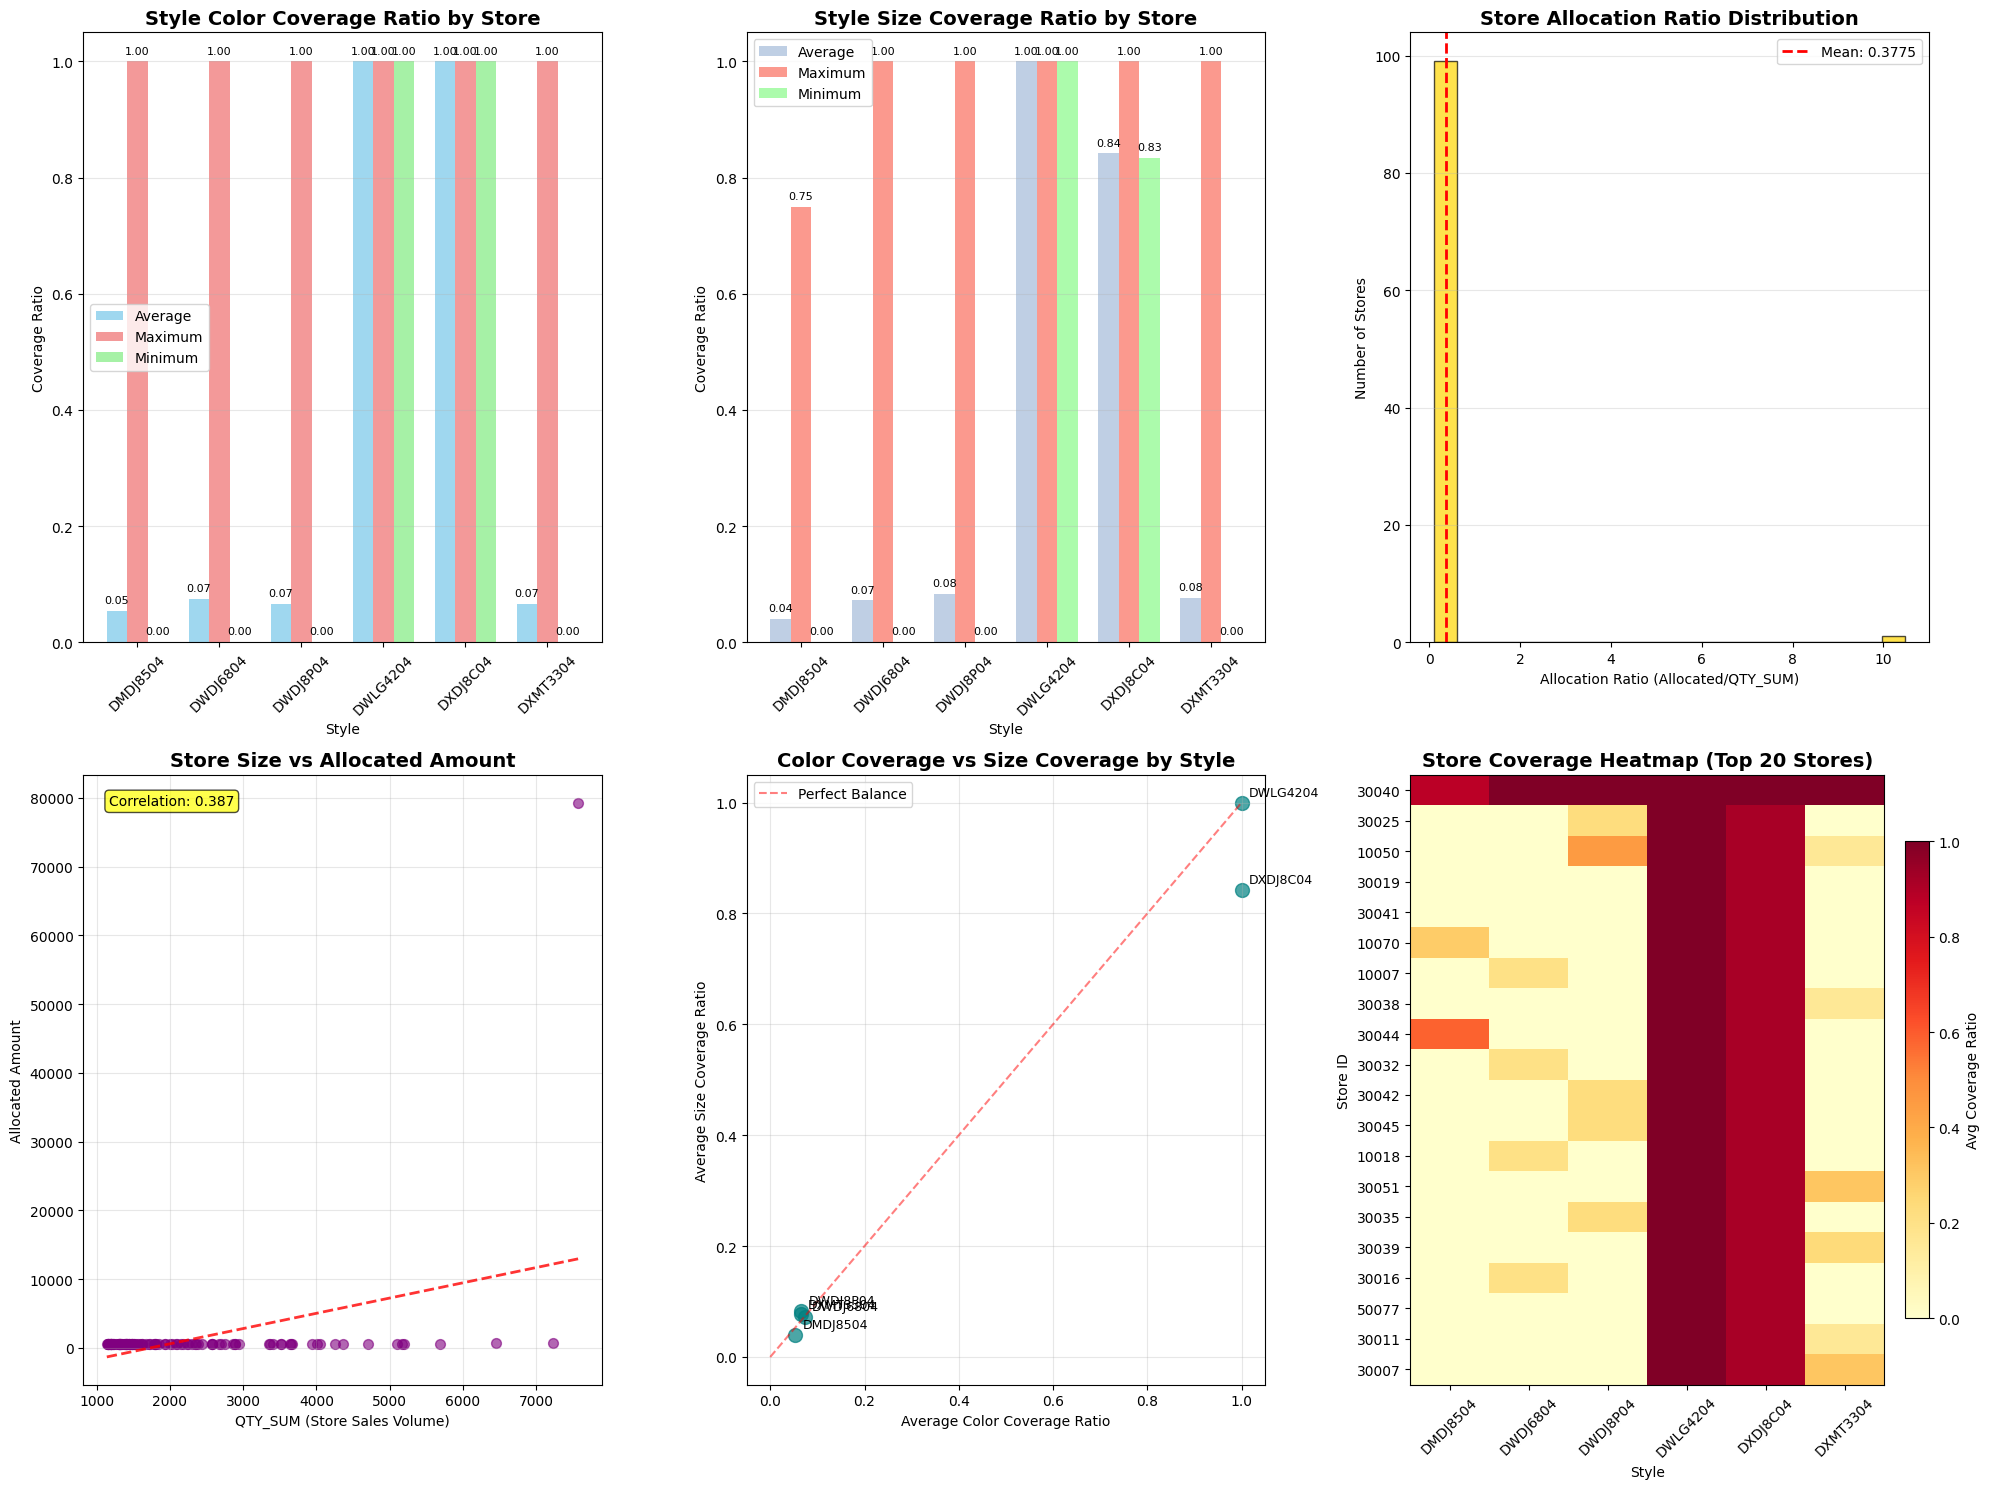

📈 시각화 완료!


In [15]:
# ===== 평가 메트릭 시각화 =====
print("\n🎯 평가 메트릭 시각화 시작...")

# 전체 그래프 설정
fig = plt.figure(figsize=(20, 15))

# ===== 1. 스타일별 컬러 커버리지 비율 막대 그래프 =====
plt.subplot(2, 3, 1)
style_names = list(style_color_coverage.keys())
color_avg_ratios = [style_color_coverage[s]['avg_ratio'] for s in style_names]
color_max_ratios = [style_color_coverage[s]['max_ratio'] for s in style_names]
color_min_ratios = [style_color_coverage[s]['min_ratio'] for s in style_names]

x_pos = range(len(style_names))
bars1 = plt.bar([x-0.25 for x in x_pos], color_avg_ratios, width=0.25, 
                label='Average', color='skyblue', alpha=0.8)
bars2 = plt.bar(x_pos, color_max_ratios, width=0.25, 
                label='Maximum', color='lightcoral', alpha=0.8)
bars3 = plt.bar([x+0.25 for x in x_pos], color_min_ratios, width=0.25, 
                label='Minimum', color='lightgreen', alpha=0.8)

plt.title('Style Color Coverage Ratio by Store', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Coverage Ratio')
plt.xticks(x_pos, [s[:8] for s in style_names], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 값 표시
for i, (avg, max_val, min_val) in enumerate(zip(color_avg_ratios, color_max_ratios, color_min_ratios)):
    plt.text(i-0.25, avg + 0.01, f'{avg:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i, max_val + 0.01, f'{max_val:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i+0.25, min_val + 0.01, f'{min_val:.2f}', ha='center', va='bottom', fontsize=8)

# ===== 2. 스타일별 사이즈 커버리지 비율 막대 그래프 =====
plt.subplot(2, 3, 2)
size_avg_ratios = [style_size_coverage[s]['avg_ratio'] for s in style_names]
size_max_ratios = [style_size_coverage[s]['max_ratio'] for s in style_names]
size_min_ratios = [style_size_coverage[s]['min_ratio'] for s in style_names]

bars1 = plt.bar([x-0.25 for x in x_pos], size_avg_ratios, width=0.25, 
                label='Average', color='lightsteelblue', alpha=0.8)
bars2 = plt.bar(x_pos, size_max_ratios, width=0.25, 
                label='Maximum', color='salmon', alpha=0.8)
bars3 = plt.bar([x+0.25 for x in x_pos], size_min_ratios, width=0.25, 
                label='Minimum', color='palegreen', alpha=0.8)

plt.title('Style Size Coverage Ratio by Store', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Coverage Ratio')
plt.xticks(x_pos, [s[:8] for s in style_names], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 값 표시
for i, (avg, max_val, min_val) in enumerate(zip(size_avg_ratios, size_max_ratios, size_min_ratios)):
    plt.text(i-0.25, avg + 0.01, f'{avg:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i, max_val + 0.01, f'{max_val:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i+0.25, min_val + 0.01, f'{min_val:.2f}', ha='center', va='bottom', fontsize=8)

# ===== 3. 매장별 분배 적정성 비율 히스토그램 =====
plt.subplot(2, 3, 3)
allocation_ratios = [data['ratio'] for data in store_allocation_ratio.values()]

plt.hist(allocation_ratios, bins=20, color='gold', alpha=0.7, edgecolor='black')
plt.title('Store Allocation Ratio Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Allocation Ratio (Allocated/QTY_SUM)')
plt.ylabel('Number of Stores')
plt.grid(axis='y', alpha=0.3)

# 통계값 표시
mean_ratio = sum(allocation_ratios) / len(allocation_ratios)
plt.axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ratio:.4f}')
plt.legend()

# ===== 4. 매장 규모 vs 할당량 산점도 =====
plt.subplot(2, 3, 4)
qty_sums = [store_allocation_ratio[j]['qty_sum'] for j in stores]
allocated_amounts = [store_allocation_ratio[j]['allocated'] for j in stores]

plt.scatter(qty_sums, allocated_amounts, alpha=0.6, s=50, color='purple')
plt.title('Store Size vs Allocated Amount', fontsize=14, fontweight='bold')
plt.xlabel('QTY_SUM (Store Sales Volume)')
plt.ylabel('Allocated Amount')
plt.grid(True, alpha=0.3)

# 추세선 추가
import numpy as np
z = np.polyfit(qty_sums, allocated_amounts, 1)
p = np.poly1d(z)
plt.plot(qty_sums, p(qty_sums), "r--", alpha=0.8, linewidth=2)

# 상관계수 계산
correlation = np.corrcoef(qty_sums, allocated_amounts)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# ===== 5. 스타일별 평균 커버리지 비교 (컬러 vs 사이즈) =====
plt.subplot(2, 3, 5)
plt.scatter(color_avg_ratios, size_avg_ratios, s=100, alpha=0.7, color='teal')

for i, style in enumerate(style_names):
    plt.annotate(style[:8], (color_avg_ratios[i], size_avg_ratios[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title('Color Coverage vs Size Coverage by Style', fontsize=14, fontweight='bold')
plt.xlabel('Average Color Coverage Ratio')
plt.ylabel('Average Size Coverage Ratio')
plt.grid(True, alpha=0.3)

# 대각선 추가 (이상적인 경우)
max_val = max(max(color_avg_ratios), max(size_avg_ratios))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Balance')
plt.legend()

# ===== 6. 매장별 커버리지 히트맵 (샘플) =====
plt.subplot(2, 3, 6)

# 상위 20개 매장의 스타일별 평균 커버리지 계산
top_stores = sorted(stores, key=lambda j: sum(int(x[i][j].value()) if x[i][j].value() else 0 for i in SKUs), reverse=True)[:20]

heatmap_data = []
for j in top_stores:
    row = []
    for s in styles:
        color_ratio = len(store_coverage[j][s]['colors']) / len(K_s[s]) if len(K_s[s]) > 0 else 0
        size_ratio = len(store_coverage[j][s]['sizes']) / len(L_s[s]) if len(L_s[s]) > 0 else 0
        avg_coverage = (color_ratio + size_ratio) / 2
        row.append(avg_coverage)
    heatmap_data.append(row)

im = plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
plt.title('Store Coverage Heatmap (Top 20 Stores)', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Store ID')
plt.xticks(range(len(styles)), [s[:8] for s in styles], rotation=45)
plt.yticks(range(len(top_stores)), [str(j) for j in top_stores])

# 컬러바 추가
plt.colorbar(im, fraction=0.046, pad=0.04, label='Avg Coverage Ratio')

plt.tight_layout()
plt.show()

print("📈 시각화 완료!")


In [24]:
# ===== 상세 분석 테이블 생성 =====
print("\n📋 상세 분석 테이블 생성 중...")

# ===== 1. 스타일별 종합 분석 테이블 =====
style_analysis = []
for s in styles:
    style_data = {
        'Style': s,
        'Total_Colors': len(K_s[s]),
        'Total_Sizes': len(L_s[s]),
        'Avg_Color_Coverage': style_color_coverage[s]['avg_ratio'],
        'Max_Color_Coverage': style_color_coverage[s]['max_ratio'],
        'Min_Color_Coverage': style_color_coverage[s]['min_ratio'],
        'Avg_Size_Coverage': style_size_coverage[s]['avg_ratio'],
        'Max_Size_Coverage': style_size_coverage[s]['max_ratio'],
        'Min_Size_Coverage': style_size_coverage[s]['min_ratio'],
        'Total_SKUs': len(I_s[s]),
        'Scarce_SKUs': len([i for i in I_s[s] if i in scarce]),
        'Abundant_SKUs': len([i for i in I_s[s] if i in abundant])
    }
    style_analysis.append(style_data)

df_style_analysis = pd.DataFrame(style_analysis)
print("\n🎨 스타일별 종합 분석:")
print(df_style_analysis.round(3))

# ===== 2. 매장 성과 분석 (상위/하위 10개 매장) =====
# 종합 성과 점수 계산 (커버리지 + 적정성)
store_performance = {}
for j in stores:
    # 전체 스타일에 대한 평균 커버리지 계산
    total_color_coverage = 0
    total_size_coverage = 0
    for s in styles:
        color_ratio = len(store_coverage[j][s]['colors']) / len(K_s[s]) if len(K_s[s]) > 0 else 0
        size_ratio = len(store_coverage[j][s]['sizes']) / len(L_s[s]) if len(L_s[s]) > 0 else 0
        total_color_coverage += color_ratio
        total_size_coverage += size_ratio
    
    avg_color_coverage = total_color_coverage / len(styles)
    avg_size_coverage = total_size_coverage / len(styles)
    allocation_ratio = store_allocation_ratio[j]['ratio']
    
    # 종합 점수 (커버리지 70% + 적정성 30%)
    performance_score = (avg_color_coverage + avg_size_coverage) * 0.35 + min(allocation_ratio, 1.0) * 0.3
    
    store_performance[j] = {
        'Store_ID': j,
        'Avg_Color_Coverage': avg_color_coverage,
        'Avg_Size_Coverage': avg_size_coverage,
        'Allocation_Ratio': allocation_ratio,
        'Performance_Score': performance_score,
        'Total_Allocated': store_allocation_ratio[j]['allocated'],
        'QTY_SUM': store_allocation_ratio[j]['qty_sum']
    }

# 상위 10개 매장
top_performers = sorted(store_performance.values(), key=lambda x: x['Performance_Score'], reverse=True)[:10]
df_top_performers = pd.DataFrame(top_performers)
print("\n🏆 상위 성과 매장 Top 10:")
print(df_top_performers.round(4))

# 하위 10개 매장
bottom_performers = sorted(store_performance.values(), key=lambda x: x['Performance_Score'])[:10]
df_bottom_performers = pd.DataFrame(bottom_performers)
print("\n⚠️  하위 성과 매장 Bottom 10:")
print(df_bottom_performers.round(4))

# ===== 3. 희소 SKU 배분 효과성 분석 =====
print("\n🔍 희소 SKU 배분 효과성 분석:")
scarce_effectiveness = {}

for i in scarce:
    # 해당 SKU의 스타일, 색상, 사이즈 추출
    sku_style = df_sku.loc[df_sku['SKU']==i, 'PART_CD'].iloc[0]
    sku_color = df_sku.loc[df_sku['SKU']==i, 'COLOR_CD'].iloc[0]
    sku_size = df_sku.loc[df_sku['SKU']==i, 'SIZE_CD'].iloc[0]
    
    # 할당된 매장 수
    allocated_stores = sum(1 for j in stores if b_hat.get((i,j), 0) == 1)
    
    # 해당 색상/사이즈를 커버하게 된 매장 수 계산
    color_coverage_contribution = 0
    size_coverage_contribution = 0
    
    for j in stores:
        if b_hat.get((i,j), 0) == 1:
            # 이 SKU로 인해 색상 커버리지가 생겼는지 확인
            other_same_color_skus = [sku for sku in store_coverage[j][sku_style]['allocated_skus'] 
                                   if sku != i and df_sku.loc[df_sku['SKU']==sku, 'COLOR_CD'].iloc[0] == sku_color]
            if not other_same_color_skus:
                color_coverage_contribution += 1
            
            # 이 SKU로 인해 사이즈 커버리지가 생겼는지 확인  
            other_same_size_skus = [sku for sku in store_coverage[j][sku_style]['allocated_skus'] 
                                  if sku != i and df_sku.loc[df_sku['SKU']==sku, 'SIZE_CD'].iloc[0] == sku_size]
            if not other_same_size_skus:
                size_coverage_contribution += 1
    
    scarce_effectiveness[i] = {
        'SKU': i,
        'Style': sku_style,
        'Color': sku_color,
        'Size': sku_size,
        'Supply_Qty': A[i],
        'Allocated_Stores': allocated_stores,
        'Coverage_Utilization': allocated_stores / A[i] if A[i] > 0 else 0,
        'Color_Coverage_Contribution': color_coverage_contribution,
        'Size_Coverage_Contribution': size_coverage_contribution,
        'Total_Coverage_Impact': color_coverage_contribution + size_coverage_contribution
    }

df_scarce_effectiveness = pd.DataFrame(list(scarce_effectiveness.values()))
print(df_scarce_effectiveness.round(3))

# ===== 4. 최종 종합 평가 =====
print("\n" + "="*60)
print("                  🎯 최종 종합 평가")
print("="*60)

# 전체 성과 메트릭 계산
overall_color_coverage = sum(style_color_coverage[s]['avg_ratio'] for s in styles) / len(styles)
overall_size_coverage = sum(style_size_coverage[s]['avg_ratio'] for s in styles) / len(styles)
overall_allocation_efficiency = sum(allocation_ratios) / len(allocation_ratios)
allocation_balance = 1 - (max(allocation_ratios) - min(allocation_ratios)) / max(allocation_ratios)  # 균형성

print(f"\n📊 전체 성과 요약:")
print(f"  🎨 평균 색상 커버리지: {overall_color_coverage:.3f} ({overall_color_coverage*100:.1f}%)")
print(f"  📏 평균 사이즈 커버리지: {overall_size_coverage:.3f} ({overall_size_coverage*100:.1f}%)")
print(f"  ⚖️  평균 분배 효율성: {overall_allocation_efficiency:.4f}")
print(f"  🎯 분배 균형성: {allocation_balance:.3f} ({allocation_balance*100:.1f}%)")

# 개선 권장사항
print(f"\n💡 개선 권장사항:")

# 낮은 커버리지 스타일 식별
low_coverage_styles = [(s, style_color_coverage[s]['avg_ratio'], style_size_coverage[s]['avg_ratio']) 
                       for s in styles 
                       if style_color_coverage[s]['avg_ratio'] < 0.5 or style_size_coverage[s]['avg_ratio'] < 0.5]

if low_coverage_styles:
    print("  📉 커버리지 개선 필요 스타일:")
    for style, color_cov, size_cov in low_coverage_styles:
        print(f"    - {style}: 색상 {color_cov:.2f}, 사이즈 {size_cov:.2f}")

# 분배 불균형 매장 식별
high_ratio_stores = [j for j in stores if store_allocation_ratio[j]['ratio'] > overall_allocation_efficiency * 2]
low_ratio_stores = [j for j in stores if store_allocation_ratio[j]['ratio'] < overall_allocation_efficiency * 0.5]

if high_ratio_stores:
    print(f"  📈 과도 분배 매장 ({len(high_ratio_stores)}개): {high_ratio_stores[:5]}{'...' if len(high_ratio_stores) > 5 else ''}")
if low_ratio_stores:
    print(f"  📉 과소 분배 매장 ({len(low_ratio_stores)}개): {low_ratio_stores[:5]}{'...' if len(low_ratio_stores) > 5 else ''}")

# 종합 등급 산정
total_score = (overall_color_coverage + overall_size_coverage + min(overall_allocation_efficiency, 1.0) + allocation_balance) / 4

if total_score >= 0.8:
    grade = "A (우수)"
elif total_score >= 0.7:
    grade = "B (양호)"
elif total_score >= 0.6:
    grade = "C (보통)"
elif total_score >= 0.5:
    grade = "D (개선필요)"
else:
    grade = "F (재검토필요)"

print(f"\n🏅 종합 평가 등급: {grade} (점수: {total_score:.3f})")

print("\n✅ 배분 결과 평가 완료!")

# 결과를 CSV로 저장
df_style_analysis.to_csv('../output/style_analysis.csv', index=False, encoding='utf-8-sig')
df_top_performers.to_csv('../output/top_performers.csv', index=False, encoding='utf-8-sig')
df_scarce_effectiveness.to_csv('../output/scarce_effectiveness.csv', index=False, encoding='utf-8-sig')

print(f"\n💾 분석 결과가 CSV 파일로 저장되었습니다:")
print(f"  - 스타일 분석: ../output/style_analysis.csv")
print(f"  - 상위 성과 매장: ../output/top_performers.csv") 
print(f"  - 희소 SKU 효과성: ../output/scarce_effectiveness.csv")



📋 상세 분석 테이블 생성 중...

🎨 스타일별 종합 분석:
       Style  Total_Colors  Total_Sizes  Avg_Color_Coverage  \
0  DMDJ85046             3            4               0.043   
1  DWDJ68046             5            5               0.086   
2  DWDJ8P046             5            4               0.064   
3  DWLG42044             2            4               0.665   
4  DXDJ8C046             9            6               0.268   
5  DXMT33044             7            6               0.071   

   Max_Color_Coverage  Min_Color_Coverage  Avg_Size_Coverage  \
0                 1.0               0.000              0.035   
1                 1.0               0.000              0.086   
2                 1.0               0.000              0.078   
3                 1.0               0.500              0.265   
4                 1.0               0.222              0.357   
5                 1.0               0.000              0.080   

   Max_Size_Coverage  Min_Size_Coverage  Total_SKUs  Scarce_SKUs  \
0    